In [1571]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Set random seed for reproducibility


In [1572]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration


In [1573]:
device = "mps"
print(f"Using device: {device}")

Using device: mps


Load and prepare data


In [1574]:
data = pd.read_csv("./data/rnn_full_data.csv")

Create a unique location identifier and time key


In [1575]:
data["location_id"] = (
    data["Location Group"].astype(str) + "_" + data["District"].astype(str)
)
data["time_key"] = data["Year"] * 12 + data["Month"]
data

,Year,Month,Location Group,District,crime_count,Season,sin_month,cos_month,location_id,time_key
0,2020,1,ABANDONED,1.0,0.0,Winter,0.0,1.000000,ABANDONED_1.0,24241
1,2020,1,ABANDONED,2.0,1.0,Winter,0.0,1.000000,ABANDONED_2.0,24241
2,2020,1,ABANDONED,3.0,0.0,Winter,0.0,1.000000,ABANDONED_3.0,24241
3,2020,1,ABANDONED,4.0,0.0,Winter,0.0,1.000000,ABANDONED_4.0,24241
4,2020,1,ABANDONED,5.0,1.0,Winter,0.0,1.000000,ABANDONED_5.0,24241
...,...,...,...,...,...,...,...,...,...,...
27595,2024,12,WATER,20.0,0.0,Winter,-0.5,0.866025,WATER_20.0,24300
27596,2024,12,WATER,22.0,0.0,Winter,-0.5,0.866025,WATER_22.0,24300
27597,2024,12,WATER,24.0,0.0,Winter,-0.5,0.866025,WATER_24.0,24300
27598,2024,12,WATER,25.0,0.0,Winter,-0.5,0.866025,WATER_25.0,24300


Get unique locations and time points


In [1576]:
locations = data["location_id"].unique()
locations.sort()
n_location = len(locations)
time_points = sorted(data["time_key"].unique())
n_time = len(time_points)
location_map = {location: i for i, location in enumerate(locations)}
time_map = {time_point: i for i, time_point in enumerate(time_points)}
data["location_id"] = data["location_id"].map(location_map)
data["time_id"] = data["time_key"].map(time_map)
print(location_map)
print(time_map)

{'ABANDONED_1.0': 0, 'ABANDONED_10.0': 1, 'ABANDONED_11.0': 2, 'ABANDONED_12.0': 3, 'ABANDONED_14.0': 4, 'ABANDONED_15.0': 5, 'ABANDONED_16.0': 6, 'ABANDONED_17.0': 7, 'ABANDONED_18.0': 8, 'ABANDONED_19.0': 9, 'ABANDONED_2.0': 10, 'ABANDONED_20.0': 11, 'ABANDONED_22.0': 12, 'ABANDONED_24.0': 13, 'ABANDONED_25.0': 14, 'ABANDONED_3.0': 15, 'ABANDONED_31.0': 16, 'ABANDONED_4.0': 17, 'ABANDONED_5.0': 18, 'ABANDONED_6.0': 19, 'ABANDONED_7.0': 20, 'ABANDONED_8.0': 21, 'ABANDONED_9.0': 22, 'AIRPORT_1.0': 23, 'AIRPORT_10.0': 24, 'AIRPORT_11.0': 25, 'AIRPORT_12.0': 26, 'AIRPORT_14.0': 27, 'AIRPORT_15.0': 28, 'AIRPORT_16.0': 29, 'AIRPORT_17.0': 30, 'AIRPORT_18.0': 31, 'AIRPORT_19.0': 32, 'AIRPORT_2.0': 33, 'AIRPORT_20.0': 34, 'AIRPORT_22.0': 35, 'AIRPORT_24.0': 36, 'AIRPORT_25.0': 37, 'AIRPORT_3.0': 38, 'AIRPORT_31.0': 39, 'AIRPORT_4.0': 40, 'AIRPORT_5.0': 41, 'AIRPORT_6.0': 42, 'AIRPORT_7.0': 43, 'AIRPORT_8.0': 44, 'AIRPORT_9.0': 45, 'CEMETERY_1.0': 46, 'CEMETERY_10.0': 47, 'CEMETERY_11.0': 48,

In [1577]:
print(f"Number of unique locations: {len(locations)}")
print(f"Number of time points: {len(time_points)}")
data.sort_values("crime_count", ascending=False)

Number of unique locations: 460
Number of time points: 60


,Year,Month,Location Group,District,crime_count,Season,sin_month,cos_month,location_id,time_key,time_id
3621,2020,8,STREET_OUTDOOR,11.0,768.0,Summer,-5.000000e-01,-8.660254e-01,393,24248,7
19261,2023,6,STREET_OUTDOOR,11.0,745.0,Summer,5.000000e-01,-8.660254e-01,393,24282,41
3161,2020,7,STREET_OUTDOOR,11.0,740.0,Summer,1.224647e-16,-1.000000e+00,393,24247,6
19721,2023,7,STREET_OUTDOOR,11.0,722.0,Summer,1.224647e-16,-1.000000e+00,393,24283,42
4541,2020,10,STREET_OUTDOOR,11.0,716.0,Fall,-1.000000e+00,-1.836970e-16,393,24250,9
...,...,...,...,...,...,...,...,...,...,...,...
13412,2022,6,COIN_OPERATED,4.0,0.0,Summer,5.000000e-01,-8.660254e-01,86,24270,29
13413,2022,6,COIN_OPERATED,5.0,0.0,Summer,5.000000e-01,-8.660254e-01,87,24270,29
13414,2022,6,COIN_OPERATED,6.0,0.0,Summer,5.000000e-01,-8.660254e-01,88,24270,29
13415,2022,6,COIN_OPERATED,7.0,0.0,Summer,5.000000e-01,-8.660254e-01,89,24270,29


In [1578]:
features = ["crime_count", "location_id"]

In [1579]:
matrix = np.zeros((len(time_points), len(locations), 2))

In [1580]:
for _, row in data.iterrows():
    location_id = row["location_id"]
    time_id = row["time_id"]
    matrix[time_id, location_id] = row[["crime_count", "location_id"]]
matrix.shape

(60, 460, 2)

In [1581]:
min_value = matrix[:48, :, 0].min(axis=0)  # Shape: (460,)
max_value = matrix[:48, :, 0].max(axis=0)  # Shape: (460,)
max_min = max_value - min_value
max_min[max_min == 0] = 1  # Avoid division by zero
matrix_scaled = matrix.copy()
matrix_scaled[:, :, 0] = (matrix[:, :, 0] - min_value) / max_min

In [1582]:
seq_length = 12

In [1583]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        target = data[i + seq_length, :, 0]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

Create sequences


In [1584]:
X, y = create_sequences(matrix_scaled, seq_length)
print(X.shape)
print(y.shape)

(48, 12, 460, 2)
(48, 460)


In [1585]:
print(f"Number of sequences: {len(X)}")
print(
    f"Input shape: {X.shape}"
)  # [n_sequences, sequence_length, n_locations, n_features]
print(f"Target shape: {y.shape}")  # [n_sequences, n_locations]

Number of sequences: 48
Input shape: (48, 12, 460, 2)
Target shape: (48, 460)


In [1586]:
train_size = int(0.75 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [1587]:
print(f"Training sequences: {len(X_train)}")
print(f"Validation sequences: {len(X_val)}")

Training sequences: 36
Validation sequences: 12


Convert to PyTorch tensors


In [1588]:
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

Define the RNN model


In [1589]:
input_size = 1
hidden_size = 32
batch_size = 16
num_layers = 2
embed_dim = 16
output_size = 1
num_epochs = 20

In [1590]:
class CrimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, embed_dim, num_layers, output_size):
        super(CrimeLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.location_embedding = nn.Embedding(len(locations), embed_dim)
        self.lstm = nn.LSTM(
            input_size=input_size + embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: [seq_length, batch_size, n_features (crime_count, location_id)]

        batch_size = x.size(1)
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        # location_embed: [seq_length, batch_size, embed_dim]
        location_embed = self.location_embedding(x[:, :, 1].long())
        # crime: [seq_length, batch_size, 1]
        crime = x[:, :, 0].unsqueeze(-1)
        # Combine crime and location embeddings
        x = torch.cat((crime, location_embed), dim=-1)
        # x: [seq_length, batch_size, embed_dim + 1]
        output, (_, _) = self.lstm(x, (h_0, c_0))
        output = self.fc1(output[-1])
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)

        return output

In [1591]:
print(X_train.shape)
model = CrimeLSTM(input_size, hidden_size, embed_dim, num_layers, output_size).to(
    device
)
print(model)

(36, 12, 460, 2)
CrimeLSTM(
  (location_embedding): Embedding(460, 16)
  (lstm): LSTM(17, 32, num_layers=2)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


Define loss function and optimizer


In [1592]:
criterion = nn.MSELoss()

Training function


In [1593]:
# Validation
def evaluate_model(model, X_val_tensor, y_val_tensor):
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for i in range(len(X_val)):
            for batch in range(0, n_location, batch_size):
                optimizer.zero_grad()
                sequence = X_train_tensor[i, :, batch : batch + batch_size]
                target = y_train_tensor[i, batch : batch + batch_size]
                score = model(sequence)
                loss = criterion(score, target.unsqueeze(1))
                optimizer.step()
                val_loss += loss.item()
                num_batches += 1
    total_val_loss = val_loss / num_batches
    return total_val_loss

In [ ]:
start_time = time.time()
n_location = len(locations)
train_losses = []
val_losses = []
my_lr = 0.01
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    my_lr = my_lr / 1.1
    optimizer = torch.optim.Adam(model.parameters(), lr=my_lr)
    for i in range(len(X_train)):
        for batch in range(0, n_location, batch_size):
            optimizer.zero_grad()
            sequence = X_train_tensor[i, :, batch : batch + batch_size]
            target = y_train_tensor[i, batch : batch + batch_size]
            score = model(sequence)
            loss = criterion(score, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            num_batches += 1
    train_loss /= num_batches
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, X_val_tensor, y_val_tensor)
    val_losses.append(val_loss)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, learning rate: {my_lr:.12f}, time: {time.time() - start_time:.2f} seconds"
    )

Epoch [1/20], Train Loss: 0.064550183522, Val Loss: 0.053144652391, learning rate: 0.009090909091, time: 8.91 seconds
Epoch [2/20], Train Loss: 0.052729067659, Val Loss: 0.053263602101, learning rate: 0.008264462810, time: 17.16 seconds
Epoch [3/20], Train Loss: 0.049078762368, Val Loss: 0.047208141592, learning rate: 0.007513148009, time: 24.83 seconds
Epoch [4/20], Train Loss: 0.046117866905, Val Loss: 0.051747078464, learning rate: 0.006830134554, time: 32.48 seconds
Epoch [5/20], Train Loss: 0.045409011239, Val Loss: 0.050827248623, learning rate: 0.006209213231, time: 40.10 seconds
Epoch [6/20], Train Loss: 0.044509916098, Val Loss: 0.049905014881, learning rate: 0.005644739301, time: 48.84 seconds
Epoch [7/20], Train Loss: 0.043743502837, Val Loss: 0.049942538858, learning rate: 0.005131581182, time: 56.48 seconds
Epoch [8/20], Train Loss: 0.042841069071, Val Loss: 0.051135677665, learning rate: 0.004665073802, time: 64.05 seconds
Epoch [9/20], Train Loss: 0.042451463788, Val Los

Train the model


Plot training and validation loss


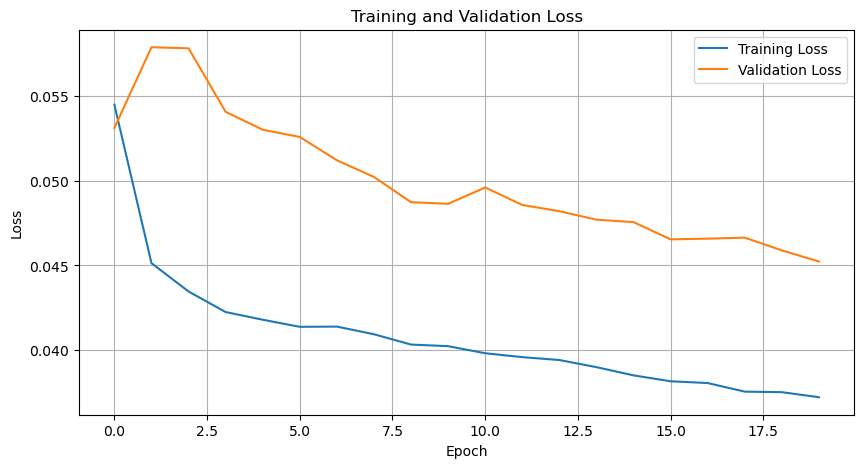

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("training_validation_loss.pdf")
plt.show()

In [ ]:
def predictions(model, X):
    num_seq, _, n_location, n_features = X.shape
    result = np.zeros((num_seq, n_location, 2))
    with torch.no_grad():
        for i in range(len(X)):
            for batch in range(0, n_location, batch_size):
                sequence = X_train_tensor[i, :, batch : batch + batch_size]
                target = y_train_tensor[i, batch : batch + batch_size]
                score = model(sequence)
                result[i, batch : batch + batch_size, 0] = score.cpu().numpy().flatten()
                result[i, batch : batch + batch_size, 1] = (
                    target.cpu().numpy().flatten()
                )
    return result

In [ ]:
prediction_model = model.to("mps")
result = predictions(model, X_val_tensor.to("mps"))
unscaled_result = np.zeros(result.shape)
for i in range(2):
    unscaled_result[:, :, i] = result[:, :, i] * max_min + min_value

In [ ]:
unscaled_result.shape

(12, 460, 2)

In [ ]:
rounded_result = np.round(unscaled_result)
month_result = np.sum(rounded_result, axis=1)
month_result

array([[18416., 15926.],
       [18302., 12815.],
       [17709., 15646.],
       [18822., 15196.],
       [19041., 17426.],
       [20203., 18421.],
       [20500., 18787.],
       [20536., 18100.],
       [20207., 18837.],
       [20378., 18840.],
       [20216., 16834.],
       [19304., 16044.]])

RMSE: 2808.78
MAE: 2563.50
R²: -1.4943
MAPE: 16.07%


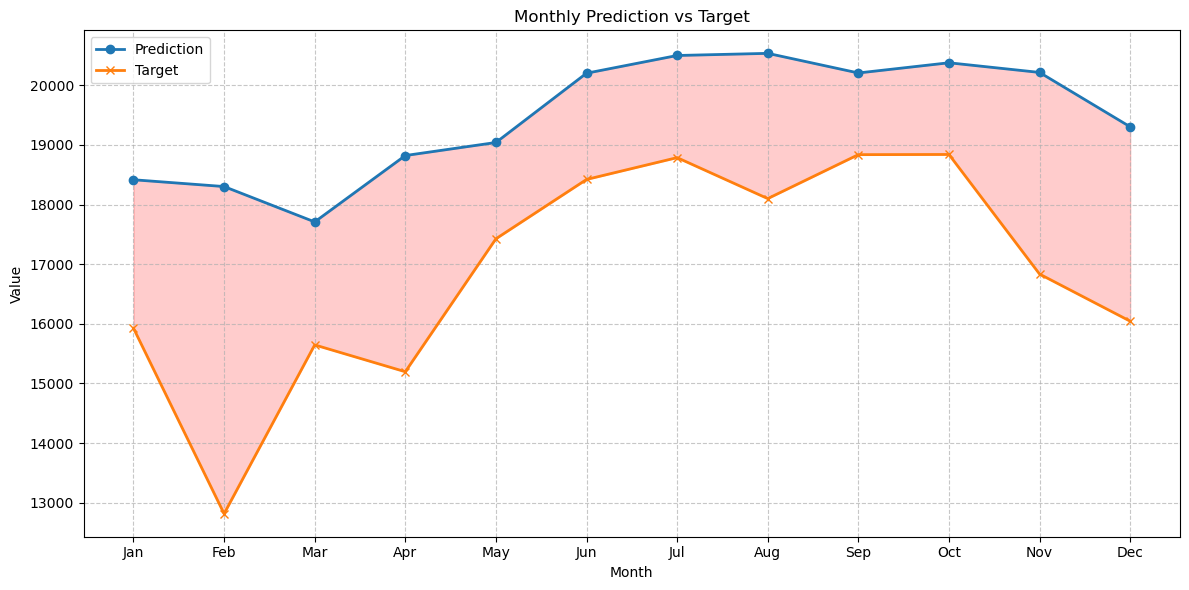


Additional Error Analysis:
Minimum absolute error: 1370.00
Maximum absolute error: 5487.00
Average error (bias): 2563.50
Standard deviation of error: 1147.93

Best performing month: Sep with absolute error of 1370.00
Worst performing month: Feb with absolute error of 5487.00


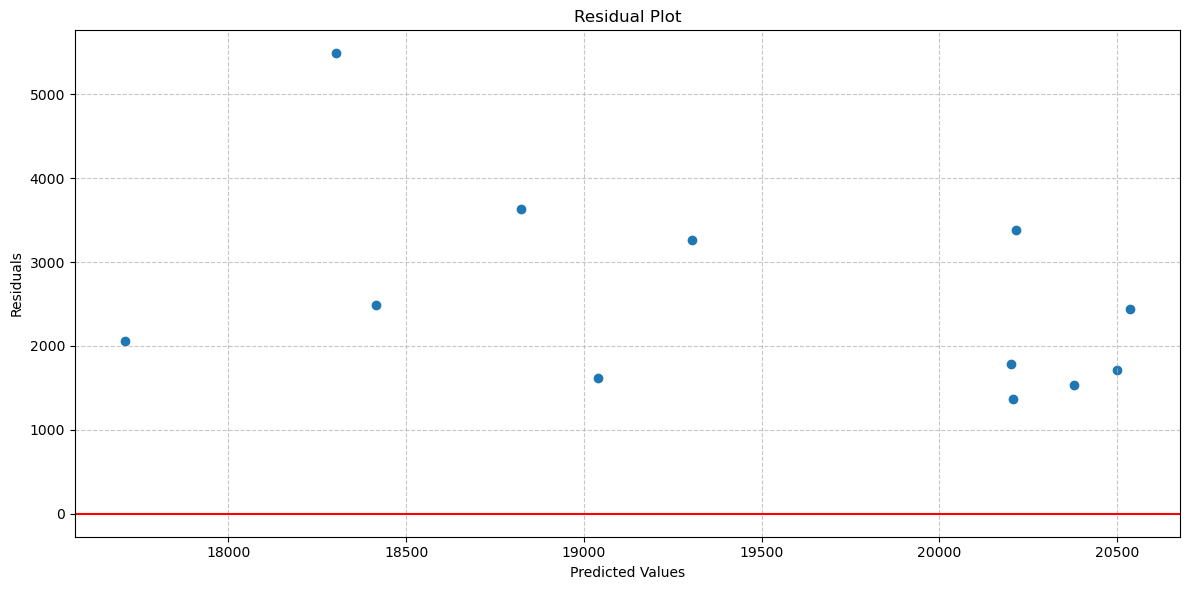

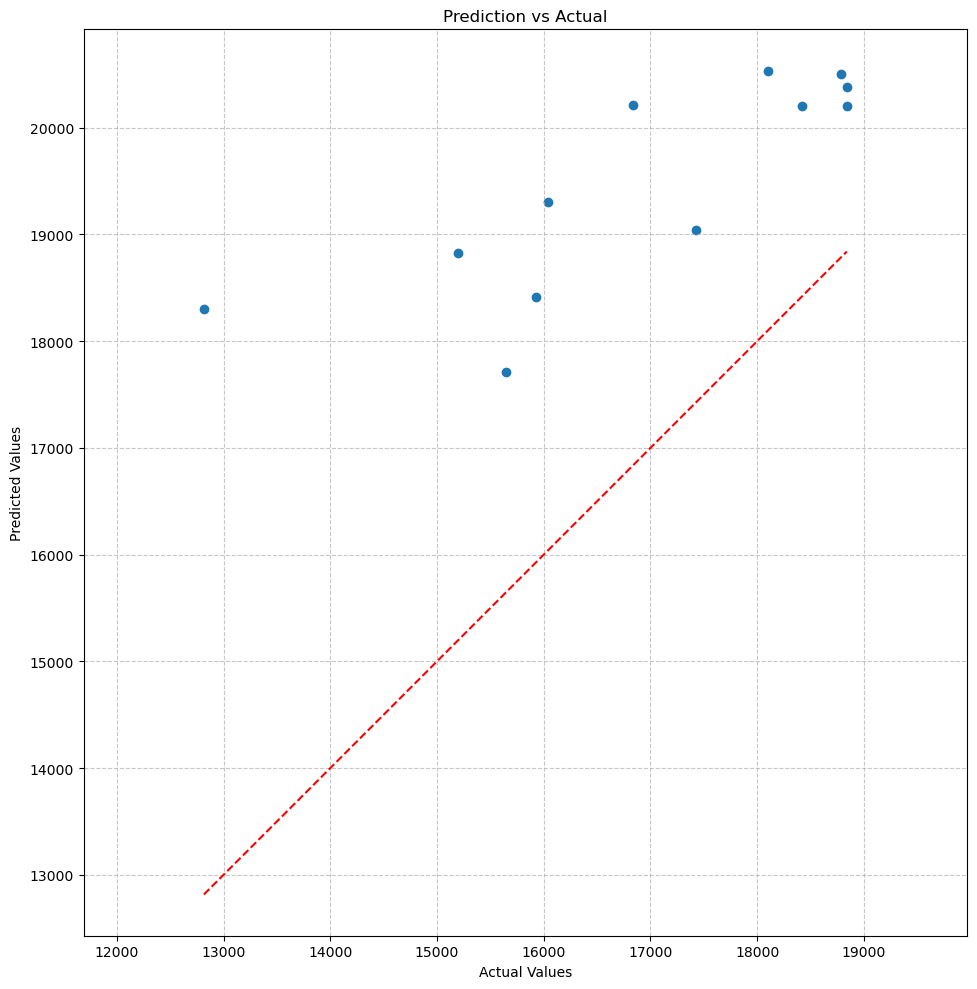

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predictions = month_result[:, 0]
targets = month_result[:, 1]

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(targets, predictions))
mae = mean_absolute_error(targets, predictions)
r2 = r2_score(targets, predictions)
mape = np.mean(np.abs((targets - predictions) / targets)) * 100

# Print metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Create months for x-axis
months = list(range(1, 13))
month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

# Plot monthly results
plt.figure(figsize=(12, 6))
plt.plot(months, predictions, marker="o", label="Prediction", linewidth=2)
plt.plot(months, targets, marker="x", label="Target", linewidth=2)
plt.fill_between(months, predictions, targets, alpha=0.2, color="red")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Month")
plt.ylabel("Value")
plt.title("Monthly Prediction vs Target")
plt.xticks(months, month_names)
plt.legend()
plt.tight_layout()

# Optional: Save the plot
# plt.savefig('monthly_prediction_vs_target.png', dpi=300)

# Display the plot
plt.show()

# Calculate additional statistics
min_error = np.min(np.abs(predictions - targets))
max_error = np.max(np.abs(predictions - targets))
avg_error = np.mean(predictions - targets)
std_error = np.std(predictions - targets)

print(f"\nAdditional Error Analysis:")
print(f"Minimum absolute error: {min_error:.2f}")
print(f"Maximum absolute error: {max_error:.2f}")
print(f"Average error (bias): {avg_error:.2f}")
print(f"Standard deviation of error: {std_error:.2f}")

# Monthly error analysis
monthly_abs_errors = np.abs(predictions - targets)
worst_month_idx = np.argmax(monthly_abs_errors)
best_month_idx = np.argmin(monthly_abs_errors)

print(
    f"\nBest performing month: {month_names[best_month_idx]} with absolute error of {monthly_abs_errors[best_month_idx]:.2f}"
)
print(
    f"Worst performing month: {month_names[worst_month_idx]} with absolute error of {monthly_abs_errors[worst_month_idx]:.2f}"
)


# If we assume rounded_result is available and has shape [months, locations]
# Here's code to visualize it as a heatmap
def plot_rounded_result(rounded_result):
    plt.figure(figsize=(12, 8))
    plt.imshow(rounded_result, cmap="viridis", aspect="auto")
    plt.colorbar(label="Value")
    plt.xlabel("Location")
    plt.ylabel("Month")
    plt.title("Heatmap of Values by Month and Location")
    plt.yticks(range(len(month_names)), month_names)
    plt.tight_layout()
    plt.show()

    # Calculate statistics per location
    location_means = np.mean(rounded_result, axis=0)
    location_stds = np.std(rounded_result, axis=0)

    print("\nLocation Statistics:")
    for i, (mean, std) in enumerate(zip(location_means, location_stds)):
        print(f"Location {i+1}: Mean = {mean:.2f}, Std = {std:.2f}")


# Uncomment and use this to plot rounded_result if available
# plot_rounded_result(rounded_result)

# Create residual plot
plt.figure(figsize=(12, 6))
residuals = predictions - targets
plt.scatter(predictions, residuals)
plt.axhline(y=0, color="r", linestyle="-")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Create a prediction vs actual scatter plot with the identity line
plt.figure(figsize=(10, 10))
plt.scatter(targets, predictions)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], "r--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs Actual")
plt.axis("equal")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()